In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.15.0


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

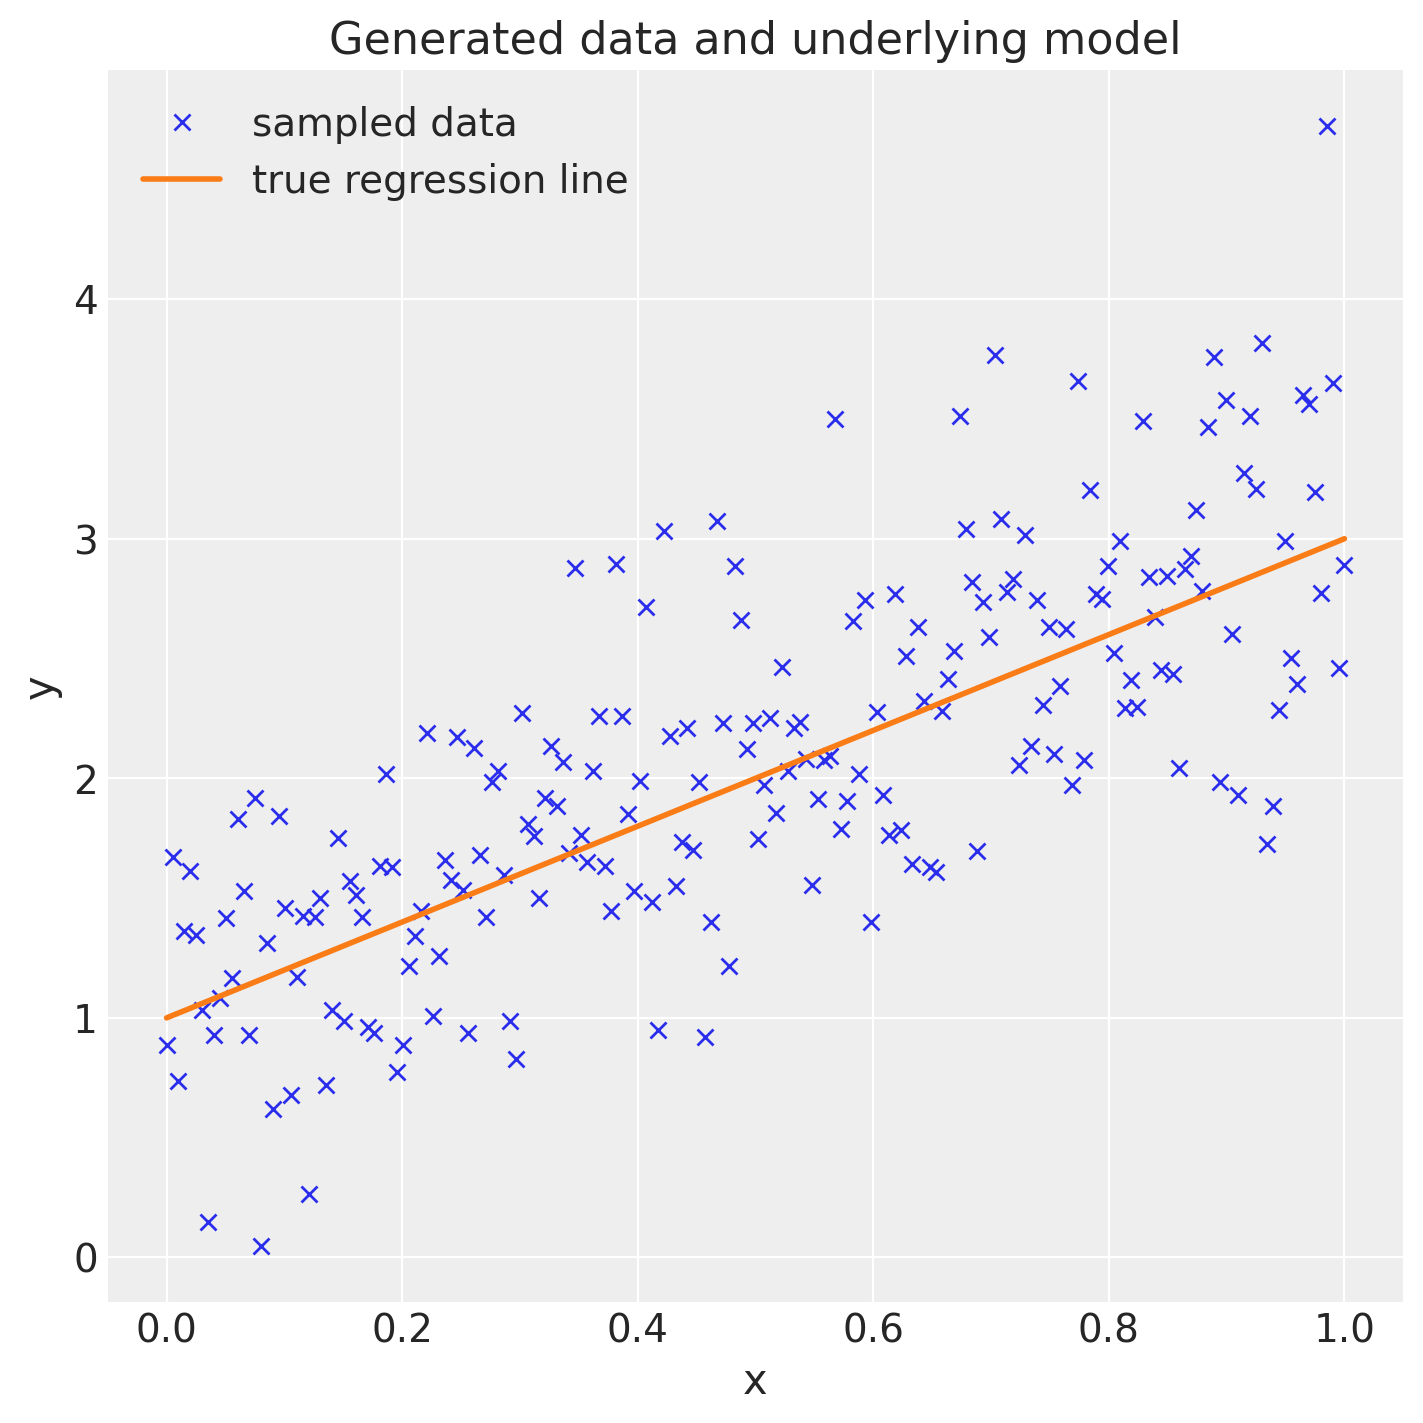

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [5]:
with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    slope = pm.Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [6]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [7]:

# Example data
x_out = np.random.randn(10)
y_out = 2 * x_out + 1 + np.random.randn(10) * 0.5  # for example purpose

# Building the model
with pm.Model() as model:
    xdata = pm.ConstantData("x", x_out, dims="obs_id")

    # Define priors
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    slope = pm.Normal("slope", mu=0, sigma=1)
    sigma = pm.HalfCauchy("sigma", beta=10)

    mu = pm.Deterministic("mu", intercept + slope * xdata, dims="obs_id")

    # Define likelihood
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_out, dims="obs_id")
    
    trace = pm.sample(draws=1000, chains=4)


/opt/homebrew/Caskroom/miniforge/base/envs/learningbayesianstatistics/lib/python3.11/site-packages/pymc/data.py:273: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [8]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [9]:
pm.sample_posterior_predictive(trace, model=model, extend_inferencedata=True)

Sampling: [y]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

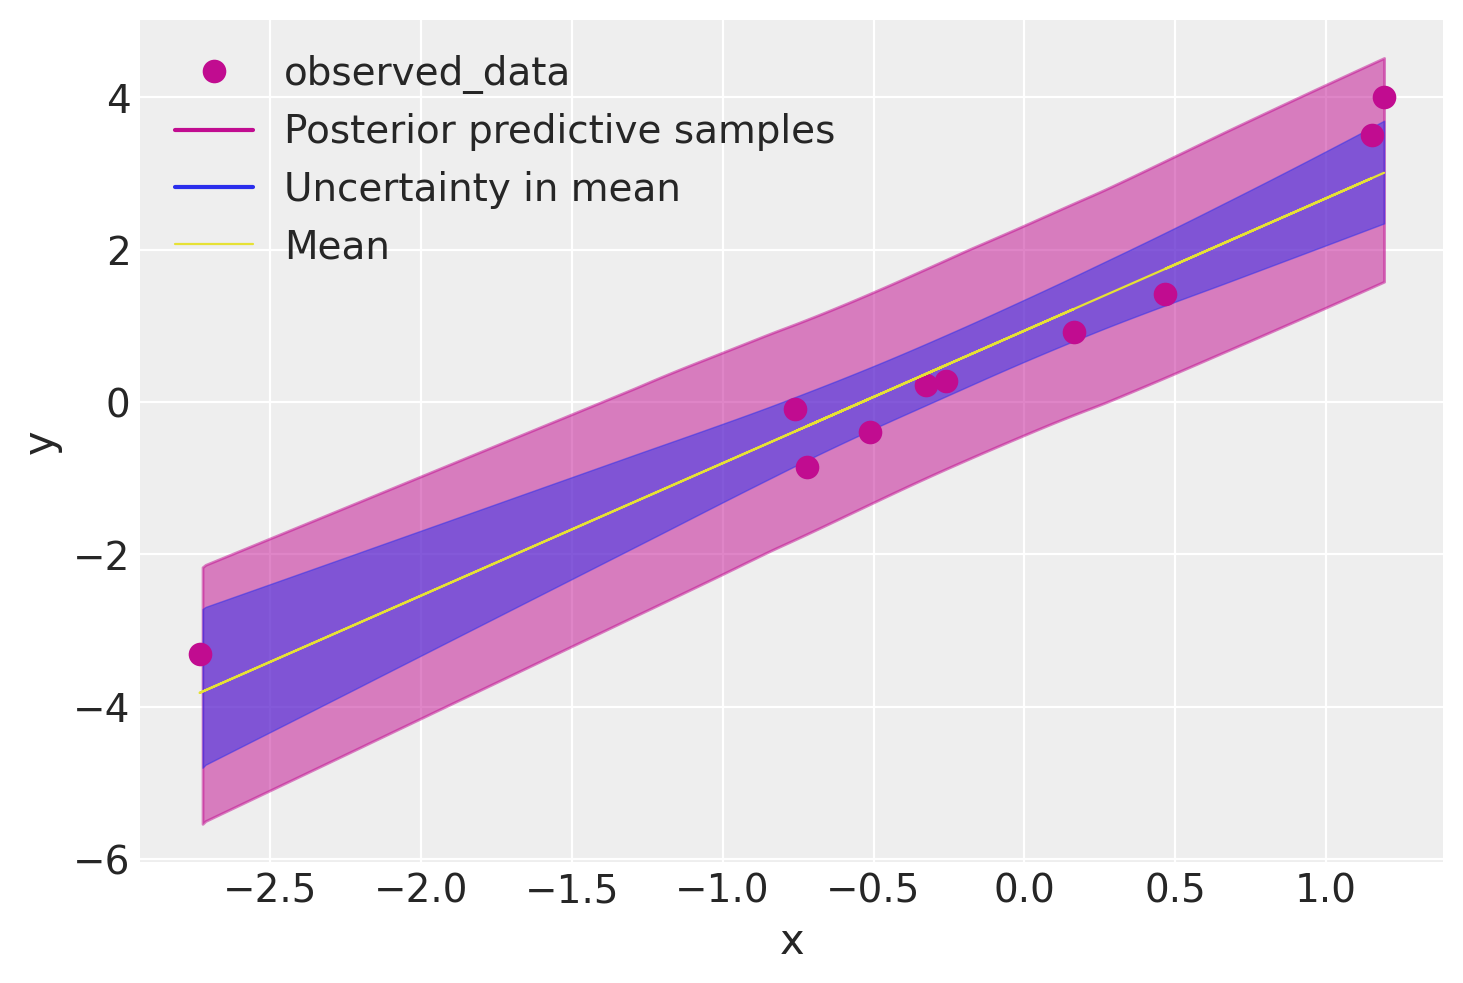

In [11]:
az.plot_lm(idata=trace, x='x', y='y', y_model='mu', kind_pp="hdi", kind_model="hdi");

Not exactly. While it's correct that the trace provides a collection of parameter values that explain the observed data ( y_\text{out} ) well, it's important to understand that the process involved in generating the trace is not simple numerical optimization.


In Bayesian statistics, the goal is not to find single "best" estimates for the parameters, but to characterize the entire posterior distribution of the parameters given the data. Here's a more precise explanation of what's going on when you execute pm.sample():



Model Specification: You've specified a probabilistic model with priors (intercept, slope, and sigma) and a likelihood function based on the observed data (y_out).

Posterior Distribution: The posterior distribution represents the combined information from the priors and the likelihood. This distribution expresses the probabilities of the different parameter values given the observed data.

Sampling: When you call pm.sample(), PyMC uses a Markov Chain Monte Carlo (MCMC) method (usually the No-U-Turn Sampler, NUTS, which is an advanced form of Hamiltonian Monte Carlo, HMC) to draw samples from this posterior distribution. These samples, collectively known as the trace, give you an empirical approximation of the posterior distribution.

Inference: Instead of finding point estimates (like in maximum likelihood estimation or MAP estimation), the MCMC process generates a large number of samples from the posterior. This collection of samples (the trace) can then be used to summarize the posterior distribution, compute credible intervals, make predictions, and so on.


Therefore, the trace does not represent optimized point estimates, but rather a set of samples that collectively describe the posterior distribution. This allows you to perform a fuller Bayesian analysis, incorporating both the data and prior beliefs to make probabilistic statements about the parameters.


In summary: The trace contains samples from the posterior distribution of the parameters (intercept, slope, and sigma), obtained via MCMC rather than deterministic optimization. This approach provides a richer understanding of parameter uncertainties and dependencies.

In [4]:
y = np.array([2642, 3503, 4358]*10)

In [2]:
import pymc as pm
import numpy as np
from pymc.step_methods.arraystep import ArrayStep
from pymc.util import get_value_vars_from_user_vars

class QuadraticApproximation(ArrayStep):
    def __init__(self, vars, model, **kwargs):
        self.model = model
        self.vars = vars
        self.varnames = [var.name for var in vars]
        
        # Compute mode and covariance
        self.mode, self.covariance = self._compute_mode_and_covariance()
        
        vars = get_value_vars_from_user_vars(vars, model)
        
        # Create necessary function sets for pymc
        super().__init__(vars, [self._logp_fn], **kwargs)
      
    def _point_to_array(self, point):
        return np.array([point[varname] for varname in self.varnames])
    
    def _array_to_point(self, array):
        return {varname: val for varname, val in zip(self.varnames, array)}

    def _logp_fn(self, x):
        point = self._array_to_point(x)
        return self.model.logp(point)
    
    def _compute_mode_and_covariance(self):
        # Find the MAP estimate (mode of the posterior)
        map = pm.find_MAP(vars=self.vars)

        m = pm.modelcontext(None)

        for var in self.vars:
            if m.rvs_to_transforms[var] is not None:
                m.rvs_to_transforms[var] = None
                # change name so that we can use `map[var]` value
                var_value = m.rvs_to_values[var]
                var_value.name = var.name

        H = pm.find_hessian(map, vars=self.vars)
        cov = np.linalg.inv(H)
        mean = np.concatenate([np.atleast_1d(map[v.name]) for v in self.vars])
        
        return mean, cov

    def astep(self, q0, logp):
        # Generate a sample from the multivariate Gaussian approximation
        sample = np.random.multivariate_normal(self.mode, self.covariance)
        return sample, []

# Example usage:


In [7]:

with pm.Model() as model:
    # Define a simple Gaussian model
    logsigma = pm.Uniform("logsigma", -100, 100)
    mu = pm.Uniform("mu", -10000, 10000) 
    yobs = pm.Normal("y", mu=mu, sigma=pm.math.exp(logsigma), observed=y)
        
    # Instantiate and use the custom sampler
    custom_step = QuadraticApproximation(vars=[mu, logsigma], model=model)
    trace = pm.sample(1000, step=custom_step)
    
    # Analyze the trace as usual
    # pm.traceplot(trace)

/opt/homebrew/Caskroom/miniforge/base/envs/learningbayesianstatistics/lib/python3.11/site-packages/pytensor/tensor/rewriting/math.py:2465: RuntimeWarning: overflow encountered in scalar subtract
  v = reduce(np.add, num, zero) - reduce(np.add, denum, zero)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'logsigma_interval__': array(0.), 'mu_interval__': array(0.)}

Logp initial evaluation results:
{'logsigma': nan, 'mu': -1.39, 'y': -191216712.57}
You can call `model.debug()` for more details.

In [110]:
az.summary(trace, kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
mu,-0.01,0.99,-1.91,1.81
sigma,-0.02,1.01,-1.92,1.89


In [109]:
with pm.Model() as model2:
    # Define a simple Gaussian model
    mu = pm.Normal('mu', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    # y = pm.Normal('y', mu=mu, sigma=sigma, observed=np.random.randn(100))
    
    # Instantiate and use the custom sampler
    # custom_step = QuadraticApproximation(vars=[mu, sigma], model=model)
    trace2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 427 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [111]:
az.summary(trace2, kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
mu,0.00,1.00,-1.79,1.95
sigma,0.79,0.62,0.00,1.92


In [ ]:
import pymc as pm
import numpy as np
import itertools
from pymc.step_methods.arraystep import ArrayStep

class GridApproximation(ArrayStep):
    def __init__(self, vars, grid_points=100, **kwargs):
        self.model = pm.modelcontext(kwargs.pop('model'))
        self.vars = vars
        self.grid_points = grid_points
        
        # Create the grid and compute posterior probabilities
        self.grid, self.posterior_probs = self._create_grid_and_compute_probs()
        self.cumulative_probs = np.cumsum(self.posterior_probs)
        
        super().__init__(vars, **kwargs)
    
    def _create_grid_and_compute_probs(self):
        # Define grid ranges
        parameter_ranges = []
        for var in self.vars:
            start, stop = pm.util._param_range(var, self.grid_points)
            parameter_ranges.append(np.linspace(start, stop, self.grid_points))

        # Create grid points
        grid_points = list(itertools.product(*parameter_ranges))

        # Compute unnormalized posterior probabilities on the grid
        logps = np.array([self.model.logp(self._array_to_point(point)) for point in grid_points])
        posterior_probs = np.exp(logps - np.max(logps))  # for numerical stability
        posterior_probs /= np.sum(posterior_probs)

        return grid_points, posterior_probs

    def _array_to_point(self, array):
        return {var.name: val for var, val in zip(self.vars, array)}
    
    def astep(self, q0, logp):
        # Draw a sample from the grid based on posterior probabilities
        idx = np.searchsorted(self.cumulative_probs, np.random.rand())
        sample = self.grid[idx]
        return np.array(sample), []
    
# Example usage
with pm.Model() as model:
    # Define a simple Gaussian model
    mu = pm.Normal('mu', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=np.random.randn(100))
    
    # Instantiate and use the custom sampler
    custom_step = GridApproximation(vars=[mu, sigma], model=model, grid_points=100)
    trace = pm.sample(1000, step=custom_step)
    
    # Analyze the trace
    pm.traceplot(trace)

AttributeError: module pymc.util has no attribute _param_range